## Introduction

## Imports

In [181]:
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
%matplotlib inline
import random


#Increases the resolution of the graphs rendered below by changing image format into vector
%config InlineBackend.figure_formats = ['svg']

## Find, understand and visualise data

In [182]:
#Importing the dataset
dataPath = "raw_data"
df = pd.read_csv(dataPath + "/market_segmentation.csv")
#Displaying the first 10 instances of the dataset
df[0:10]

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A
5,461319,Male,Yes,56,No,Artist,0.0,Average,2.0,Cat_6,C
6,460156,Male,No,32,Yes,Healthcare,1.0,Low,3.0,Cat_6,C
7,464347,Female,No,33,Yes,Healthcare,1.0,Low,3.0,Cat_6,D
8,465015,Female,Yes,61,Yes,Engineer,0.0,Low,3.0,Cat_7,D
9,465176,Female,Yes,55,Yes,Artist,1.0,Average,4.0,Cat_6,C


In [183]:
#Dropping the ID column as it won't be useful
df = df.drop("ID", axis =1)

In [184]:
#Find the number of rows and columns in the dataset
print(df.shape)
#Find the different data types in the dataset
df.dtypes


(8068, 10)


Gender              object
Ever_Married        object
Age                  int64
Graduated           object
Profession          object
Work_Experience    float64
Spending_Score      object
Family_Size        float64
Var_1               object
Segmentation        object
dtype: object

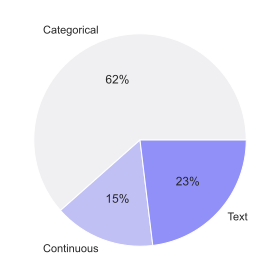

In [185]:
# Graph that illustrates the distribution of data types in this dataset
palette_color = sns.light_palette("blue")
FEATURES = [col for col in df.columns if col != 'work_year']
# Separate features into continuous and categorical features correctly
cont_features = [col for col in FEATURES if df[col].nunique() > 10]  # Adjust the threshold as needed
cat_features = [col for col in FEATURES if df[col].nunique() <= 10]  # Adjust the threshold as needed
text_features = ['job_title','company_location','employee_residence']

# Labels for plotting the pie chart
labels = ['Categorical', 'Continuous', 'Text']

# Finds the length of the each array and stores it into value
values= [len(cat_features), len(cont_features), len(text_features)]

# Plotting the pie chart
plt.pie(values, labels=labels, colors=palette_color, autopct='%.0f%%')
plt.show()

In [186]:
# Summary statistics of the data
# For things like outliers or any weird stuff
print("Summary Statistics of Numerical Variables\n", 
      df.select_dtypes(include = "number").describe(),
     "\n")

print("Summary Statistics of Categorical Variables\n",
      df.select_dtypes(include = "object").describe(),
     "\n")


Summary Statistics of Numerical Variables
                Age  Work_Experience  Family_Size
count  8068.000000      7239.000000  7733.000000
mean     43.466906         2.641663     2.850123
std      16.711696         3.406763     1.531413
min      18.000000         0.000000     1.000000
25%      30.000000         0.000000     2.000000
50%      40.000000         1.000000     3.000000
75%      53.000000         4.000000     4.000000
max      89.000000        14.000000     9.000000 

Summary Statistics of Categorical Variables
        Gender Ever_Married Graduated Profession Spending_Score  Var_1  \
count    8068         7928      7990       7944           8068   7992   
unique      2            2         2          9              3      7   
top      Male          Yes       Yes     Artist            Low  Cat_6   
freq     4417         4643      4968       2516           4878   5238   

       Segmentation  
count          8068  
unique            4  
top               D  
freq           

A quick look at the metrics we can see that work experience may be right skewed as the mean and median does not match. Additionally, outliers may be present as the max value of work experience is order of magnitude highter than other metrics.



In [187]:
# Having a look at whether is there is any missing values for this dataset


print("Summary Statistics of Missing Values \n", 
      df.isnull().sum(axis=0),
     "\n")

Summary Statistics of Missing Values 
 Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
Segmentation         0
dtype: int64 



Overall it appears like there is a lot of missing values across the columns, this means that we will most likely have to impute the data as there is too many missing points to simply just drop them. 

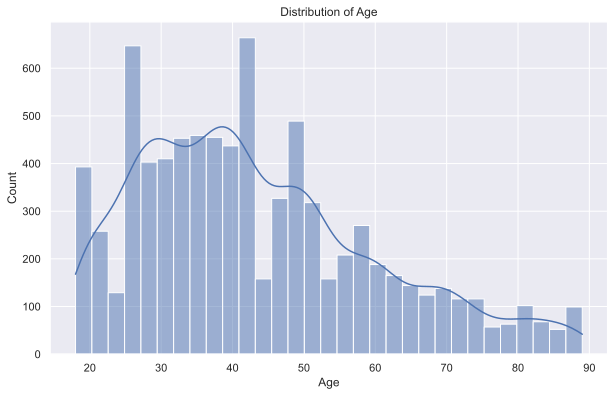

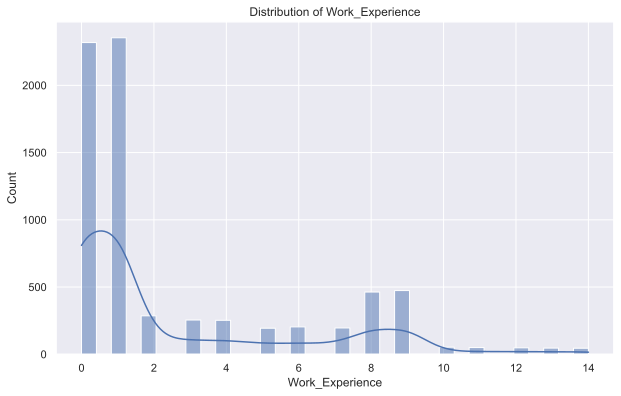

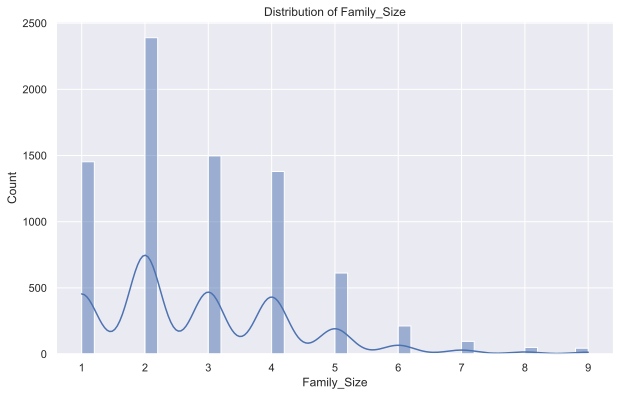

In [188]:
# This looks at the distribution of all numberical data 
for i, v in enumerate(df.select_dtypes(include = "number")):
    plt.figure(figsize=(10, 6))
    sns.histplot(df[v], kde = True)
    plt.title("Distribution of " + v)
    plt.show()


We can see that family size, work experience and age are all somewhat right skewed; lets see if we can apply log to the variables and see whether it can make it more evenly distributed.

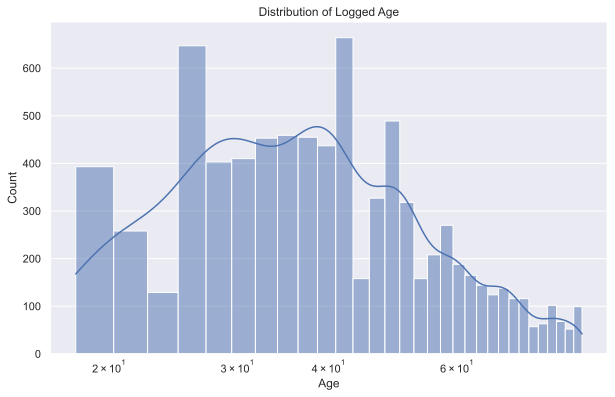

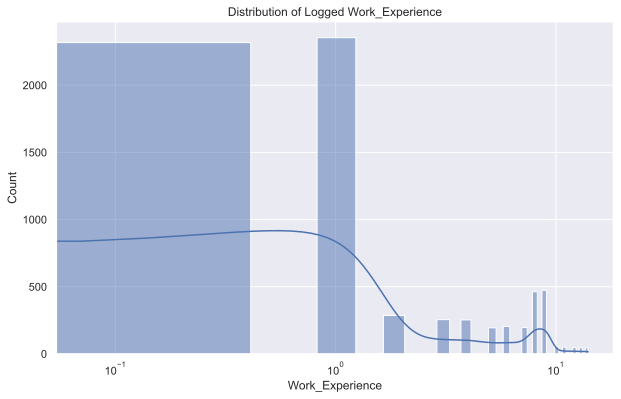

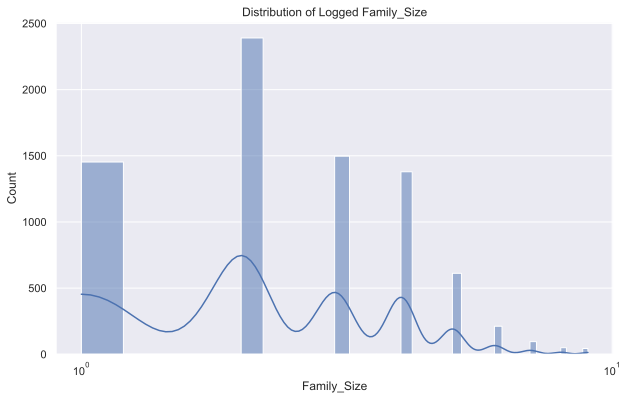

In [189]:
for i, v in enumerate(["Age", "Work_Experience", "Family_Size"]):
    plt.figure(figsize=(10, 6))
    sns.histplot(df[v], kde = True)
    plt.xscale("log")
    plt.title("Distribution of Logged " + v)
    plt.show()

After logging the relevant variables we can see that the distribution of Age and Family Size have both improved but not so much for work experience; we could look further into work experience which appears to be very odd with majority of the data being on the right side. 

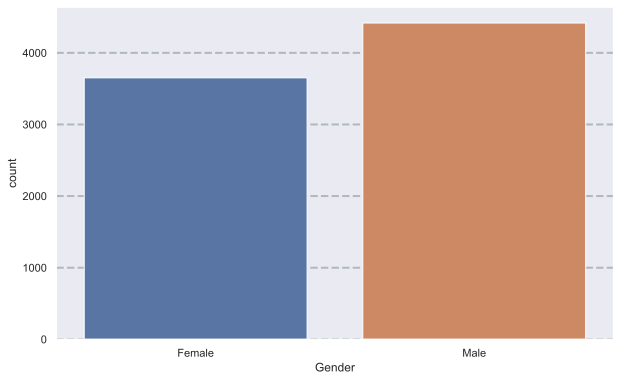

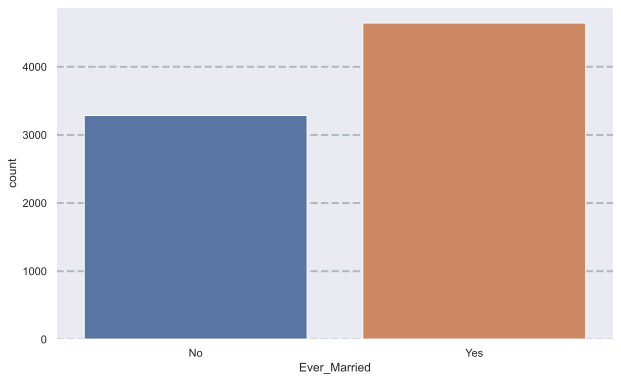

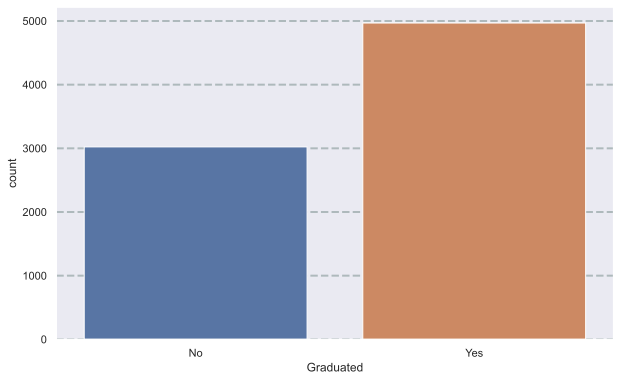

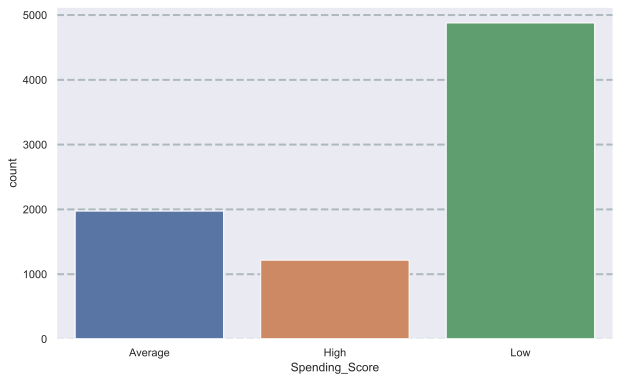

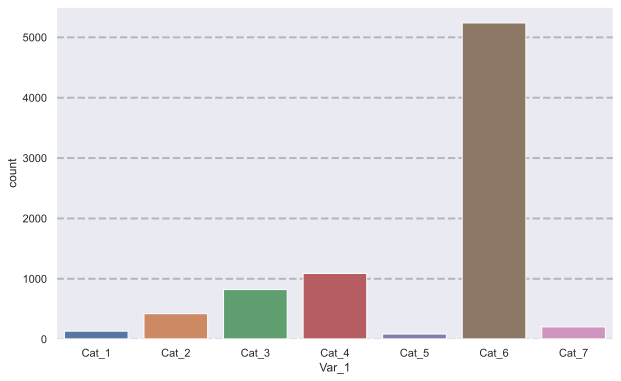

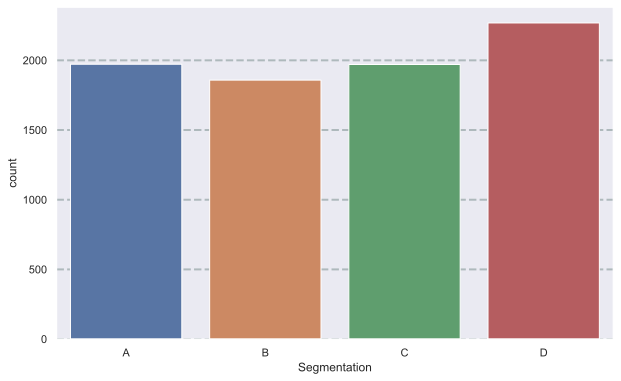

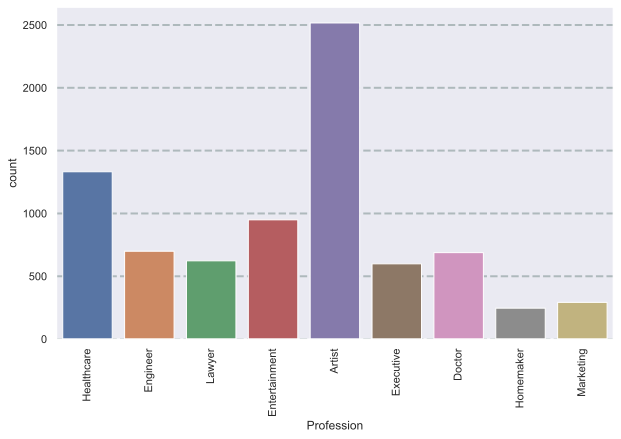

In [190]:
for i, v in enumerate(["Gender", "Ever_Married", "Graduated", "Spending_Score", "Var_1", "Segmentation"]):
    plt.figure(figsize=(10, 6))
    sns.countplot(x = df[v].astype('category'))
    plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)
    plt.show()



plt.figure(figsize=(10, 6))
sns.countplot(x="Profession", data=df)
plt.xticks(rotation=90)
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)
plt.show()


Initial look at the categorical data provides some interesting information:
- The number of individuals placed into each segement is very similar
- Majority of individuals tend to have a low spending score
- It appears like Cat_6 has the highest number of counts compared to all other options in Var_1
- Artist tend to be the most common profession in the dataset

# Clean data

As mentioned above there are a lot of missing data in work experience, family size and other variables. I will proceed to clean up the data using hot deck imputation for relevant variables that can be correlated with another or simple imputation from seaborn. I have decided to imputate the missing data instead of dropping them as the dataset isn't extremely large and dropping data may impact accuracy of results.

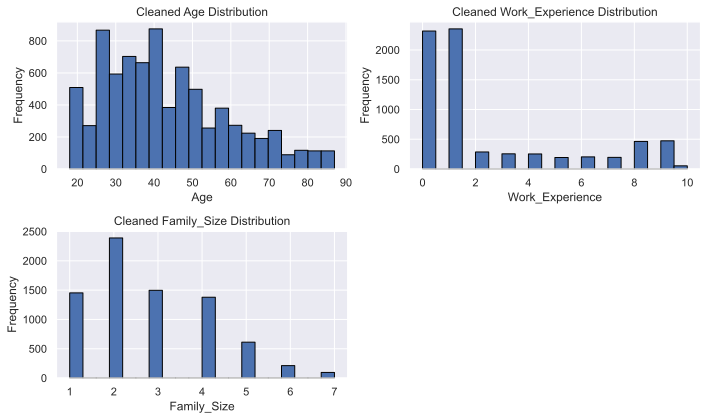

   Gender Ever_Married   Age Graduated     Profession  Work_Experience  \
0    Male           No  22.0        No     Healthcare              1.0   
1  Female          Yes  38.0       Yes       Engineer              NaN   
2  Female          Yes  67.0       Yes       Engineer              1.0   
3    Male          Yes  67.0       Yes         Lawyer              0.0   
4  Female          Yes  40.0       Yes  Entertainment              NaN   

  Spending_Score  Family_Size  Var_1 Segmentation  
0            Low          4.0  Cat_4            D  
1        Average          3.0  Cat_4            A  
2            Low          1.0  Cat_6            B  
3           High          2.0  Cat_6            B  
4           High          6.0  Cat_6            A  


In [191]:
def clean_outliers_iqr(data, factor=1.5):
    """
    Clean outliers from the data using the Interquartile Range (IQR) method.

    Parameters:
        data (pd.Series or pd.DataFrame): The data to clean.
        factor (float, optional): Multiplier for the IQR. Default is 1.5.

    Returns:
        pd.Series or pd.DataFrame: The data without outliers.
    """
    # Calculate the first quartile (Q1) and third quartile (Q3) of the data
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)

    # Calculate the Interquartile Range (IQR) by subtracting Q1 from Q3
    IQR = Q3 - Q1

    # Calculate the lower and upper bounds to identify outliers
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR

    # Return the data with outliers removed, i.e., data within the lower and upper bounds
    return data[(data >= lower_bound) & (data <= upper_bound)]

# Identify numerical columns
numerical_columns = df.select_dtypes(include='number').columns

# Clean outliers for each numerical column and update the original DataFrame
for col in numerical_columns:
    cleaned_data = clean_outliers_iqr(df[col])
    df[col] = cleaned_data

# Calculate the number of rows and columns for the subplot layout
num_cols = len(numerical_columns)
num_rows = (num_cols - 1) // 2 + 1

# Plot the cleaned distributions for all numerical columns
plt.figure(figsize=(10, 6))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(num_rows, 2, i)
    plt.hist(df[col], bins=20, edgecolor='black')
    plt.title(f'Cleaned {col} Distribution')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Now the original dataframe 'df' contains the cleaned versions of the numerical columns
print(df.head())


## Categorical features conversion

In [192]:
#Create new variable called Have_Married_Before where if they have its equivalent to 1 in this new variables and 0 if they haven't
df["Have_Married_Before"] = df.Ever_Married.replace({'Yes':1, "No": 0})
#Create new variable called have married before where if they have its equivalent to 1 in this new variables and 0 if they haven't
df["Have_Graduated"] = df.Graduated.replace({'Yes':1, 'No':0})
df.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation,Have_Married_Before,Have_Graduated
0,Male,No,22.0,No,Healthcare,1.0,Low,4.0,Cat_4,D,0.0,0.0
1,Female,Yes,38.0,Yes,Engineer,NaN,Average,3.0,Cat_4,A,1.0,1.0
2,Female,Yes,67.0,Yes,Engineer,1.0,Low,1.0,Cat_6,B,1.0,1.0
3,Male,Yes,67.0,Yes,Lawyer,0.0,High,2.0,Cat_6,B,1.0,1.0
4,Female,Yes,40.0,Yes,Entertainment,NaN,High,6.0,Cat_6,A,1.0,1.0


In [193]:
# Encoding Spending_Score using label encoding
# Using label encoding as spending score is ordinal data

# Creating a instance of label encoder
le = LabelEncoder()
# Assigning numerical values and storing in another column

df['Spending_Score_Lab'] = le.fit_transform(df['Spending_Score'])


/var/folders/k5/k1_9f5wd21sb8jb25qj3ldth0000gn/T/ipykernel_28307/3401078509.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(numeric_only=True), annot=True, mask=np.triu(df.corr()))


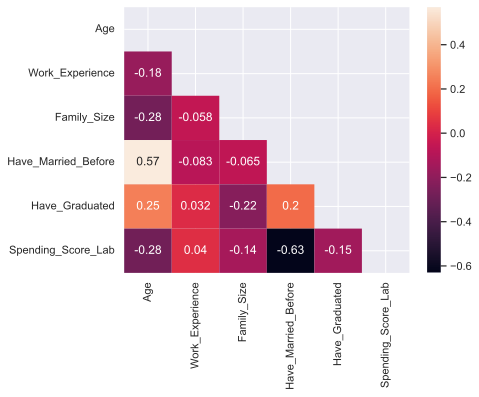

In [194]:
# Heatmap to visalise some correlation between variables 
sns.heatmap(df.corr(numeric_only=True), annot=True, mask=np.triu(df.corr()))
plt.show()

It seems like there is a very strong correlation between spending score and individuals that have married before. So we can use spending score to impute missing information about marriage for people.

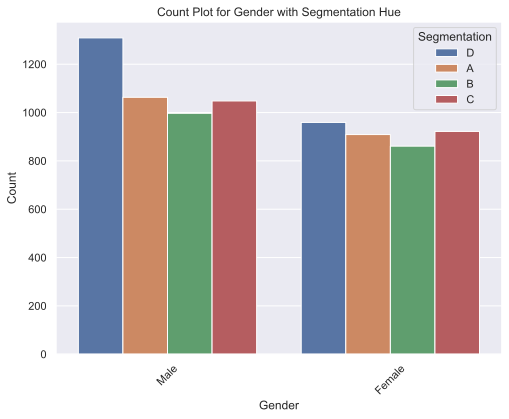

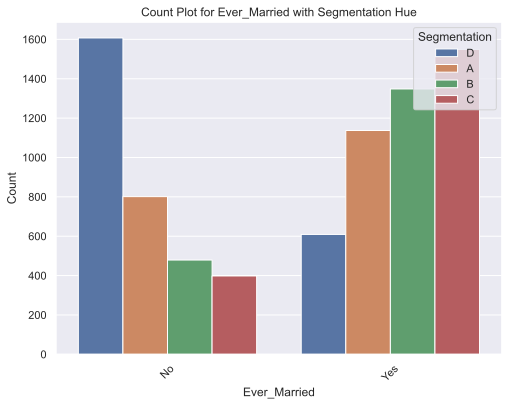

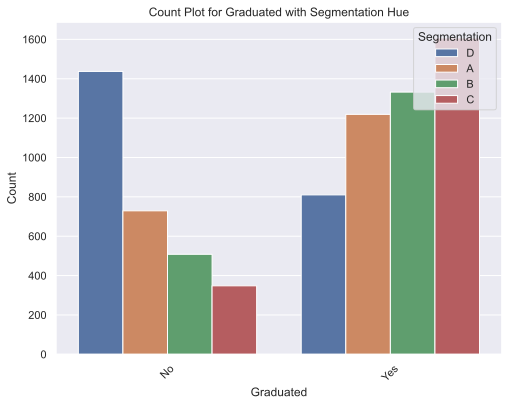

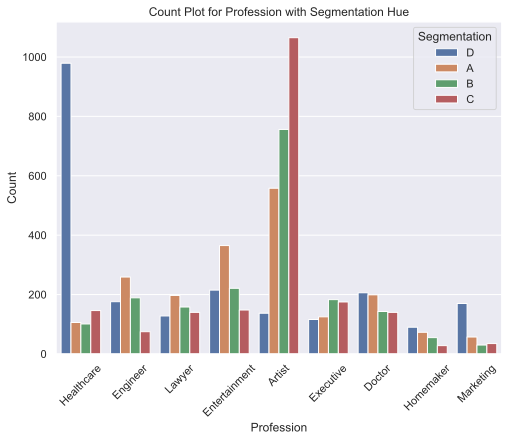

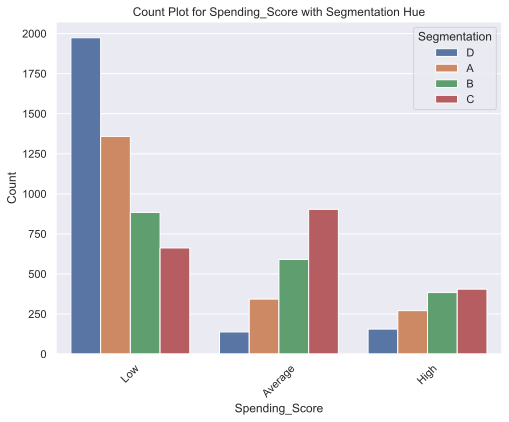

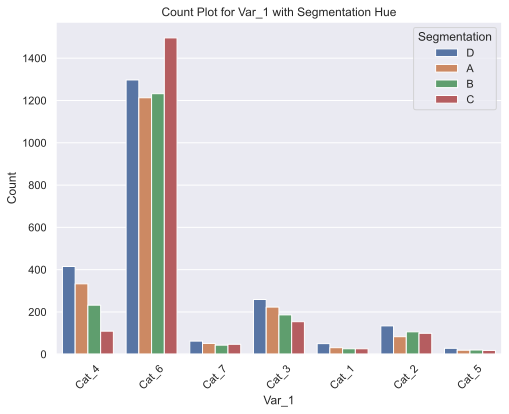

In [203]:
cat_variables = ['Gender', 'Ever_Married', 'Graduated', 'Profession','Spending_Score','Var_1']

for var in cat_variables:
    plt.figure(figsize=(8, 6))
    sns.countplot(data=df, x=var, hue='Segmentation')
    plt.title(f'Count Plot for {var} with Segmentation Hue')
    plt.xlabel(var)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.legend(title='Segmentation', loc='upper right')
    plt.show()

We can see some interesting observations froma the count plots above:

- From the gender distribution we can see that on average the segmentation of both genders are similar albeit more males are placed into category D
- Interestingly, the shape for graduated and ever married are very similar with category D being the most common for individuals that answered no and category C being the most common to individuals that answered yes.
- The distribution of individuals across the different categories are have a fairly equal shape for most professions but we can observe a signicant amount of individuals who work in healthcar are placed into D and interestingly the opposite for the artists where there is a higher number of individuals in all other categories besides D.
- In terms of the spending score individuals with a low spending score had a similar shape to individuals that said no to graduated and ever married before while the average and high groups demonstrated similar shapes to individuals that said yes to those categories.
- Lastly

<!DOCTYPE html>
<html>
<head>
  <style>
    body {
      font-family: Arial, sans-serif;
      line-height: 1.6;
      max-width: 800px;
      margin: 0 auto;
      padding: 20px;
      background-color: #f6f6f6;
      color: #4f477AA;
    }
    h1 {
      font-size: 28px;
      margin-bottom: 20px;
    }
    h2 {
      font-size: 24px;
      margin-bottom: 15px;
    }
    p {
      margin-bottom: 10px;
    }
    ul {
      margin-bottom: 10px;
      padding-left: 20px;
    }
    li {
      margin-bottom: 5px;
    }
    pre {
      background-color: #f9f9f9;
      padding: 10px;
      border-radius: 5px;
      overflow: auto;
    }
    code {
      font-family: Consolas, monospace;
    }
    .observation {
      margin-bottom: 15px;
      padding: 10px;
      border-radius: 5px;
      background-color: #fff;
      box-shadow: 0 2px 5px rgba(0, 0, 0, 0.1);
    }
  </style>
</head>
<body>
  <div class="observation">
    <h2>Interesting Observations</h2>
    <p>From the gender distribution, we can see that on average the segmentation of both genders is similar, albeit more males are placed into category D.</p>
    <p>Interestingly, the shape for graduated and ever married are very similar, with category D being the most common for individuals who answered no and category C being the most common for individuals who answered yes.</p>
    <p>The distribution of individuals across the different categories has a fairly equal shape for most professions, but we can observe a significant number of individuals who work in healthcare are placed into D, and interestingly, the opposite for artists where there is a higher number of individuals in all other categories besides D.</p>
    <p>In terms of the spending score, individuals with a low spending score had a similar shape to individuals who said no to graduated and ever married before, while the average and high groups demonstrated similar shapes to individuals who said yes to those categories.</p>
    <p>Last but not least...</p>
  </div>
</body>
</html>


In [195]:
# Cleaning Married_Before using hot deck imputation

# First we drop all the unrecorded values from the Have_Married_Before variable
# Then we sample with replacement from the list of values the number of missing values
# Lastly we replace the missing values with the sampled values

df["Have_Married_Before_Imputed"] = df["Have_Married_Before"]
for c in df["Spending_Score_Lab"].unique():
    temp = df[df["Spending_Score_Lab"] == c]
    ageDropped = temp["Have_Married_Before"].dropna().tolist()
    numMissingValues = temp["Have_Married_Before"].isna().sum()
    if numMissingValues == 0:
        continue 
    imputedAges = random.choices(ageDropped, k = numMissingValues)
    indexMissingValues = temp[temp["Have_Married_Before"].isna()].index
    df["Have_Married_Before_Imputed"] = df["Have_Married_Before_Imputed"].fillna(pd.Series(data = imputedAges, index = indexMissingValues))
print(df[["Have_Married_Before", "Have_Married_Before_Imputed"]])

      Have_Married_Before  Have_Married_Before_Imputed
0                     0.0                          0.0
1                     1.0                          1.0
2                     1.0                          1.0
3                     1.0                          1.0
4                     1.0                          1.0
...                   ...                          ...
8063                  0.0                          0.0
8064                  0.0                          0.0
8065                  0.0                          0.0
8066                  0.0                          0.0
8067                  1.0                          1.0

[8068 rows x 2 columns]


In [196]:
df.isna().sum()

Gender                            0
Ever_Married                    140
Age                              71
Graduated                        78
Profession                      124
Work_Experience                1018
Spending_Score                    0
Family_Size                     429
Var_1                            76
Segmentation                      0
Have_Married_Before             140
Have_Graduated                   78
Spending_Score_Lab                0
Have_Married_Before_Imputed       0
dtype: int64

In [197]:
# Cleaning the Family_Size variable using hot deck imputation 
# Similar to above as we can see a relatively strong correlation between age and family size we will use that for the imputation

df["Family_Size_Imputed"] = df["Family_Size"]
for c in df["Age"].unique():
    temp = df[df["Age"] == c]
    ageDropped = temp["Family_Size"].dropna().tolist()
    numMissingValues = temp["Family_Size"].isna().sum()
    if numMissingValues == 0:
        continue 
    imputedAges = random.choices(ageDropped, k = numMissingValues)
    indexMissingValues = temp[temp["Family_Size"].isna()].index
    df["Family_Size_Imputed"] = df["Family_Size_Imputed"].fillna(pd.Series(data = imputedAges, index = indexMissingValues))
print(df[["Family_Size_Imputed", "Family_Size"]])


      Family_Size_Imputed  Family_Size
0                     4.0          4.0
1                     3.0          3.0
2                     1.0          1.0
3                     2.0          2.0
4                     6.0          6.0
...                   ...          ...
8063                  7.0          7.0
8064                  4.0          4.0
8065                  1.0          1.0
8066                  4.0          4.0
8067                  3.0          3.0

[8068 rows x 2 columns]


In [198]:
df.isna().sum()

Gender                            0
Ever_Married                    140
Age                              71
Graduated                        78
Profession                      124
Work_Experience                1018
Spending_Score                    0
Family_Size                     429
Var_1                            76
Segmentation                      0
Have_Married_Before             140
Have_Graduated                   78
Spending_Score_Lab                0
Have_Married_Before_Imputed       0
Family_Size_Imputed               7
dtype: int64

In [199]:
# For the rest of the variables with missing data I opted use a replace them with the most frequent value
# One downside to this is that as work experience has a lot of missing values the data may be a bit skewed after cleaning
df_most_frequent = df.copy()

imputer = SimpleImputer(strategy='most_frequent')

df_most_frequent.iloc[:,:] = imputer.fit_transform(df_most_frequent)

In [200]:
df_most_frequent.isna().sum()

Gender                         0
Ever_Married                   0
Age                            0
Graduated                      0
Profession                     0
Work_Experience                0
Spending_Score                 0
Family_Size                    0
Var_1                          0
Segmentation                   0
Have_Married_Before            0
Have_Graduated                 0
Spending_Score_Lab             0
Have_Married_Before_Imputed    0
Family_Size_Imputed            0
dtype: int64

In [201]:
# Now that we've cleaned up the data lets encode rest of the categorical variables using one hot encoding
# This is important as machine learning models can only process numerical values
# One hot encoding of variables profession, segemenation and var_1
# Using
catVarsOneHot = ["Profession", "Segmentation","Var_1"]
dummyVars = pd.concat([pd.get_dummies(df[v], prefix = v) for v in catVarsOneHot], axis = 1)

# Joining the cleaned data and save as csv
cleanpath = "cleaned_data"
varToSave = ["Have_Married_Before", "Have_Graduated","Age","Work_Experience", "Family_Size","Spending_Score_Lab"]
pd.concat([df[varToSave], dummyVars], axis = 1).to_csv(cleanpath + "/market_segmentation_cleaned.csv", index = False)

## References
https://towardsdatascience.com/categorical-encoding-using-label-encoding-and-one-hot-encoder-911ef77fb5bd
https://www.kaggle.com/code/parulpandey/a-guide-to-handling-missing-values-in-python
https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html
https://github.com/NZMSA/2021-introduction-to-data-science/blob/main/Data%20Preparation/TitanicFINAL.ipynb
https://www.kaggle.com/code/odins0n/spaceship-titanic-eda-27-different-models